# Comparison of the models
@LuiseJedlitschka @davmar01

We decided to train the following models: MLP, Random Forest, XGBoost.
We trained them on stratified 80/20 split and on leave-one-group-out splits (one dataset as testset each).
These trained models are being compared here in their accuracy using confusion matrices and metrics (precision, recall, f1).

In [ ]:
import joblib
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from math import pi

# Suppress unnecessary warnings
import warnings
from sklearn.exceptions import InconsistentVersionWarning

warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


In [3]:
# === Setup for MLP ===
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        return self.out(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

=== Split 0 ===


TypeError: ConfusionMatrixDisplay.from_predictions() got an unexpected keyword argument 'vmin'

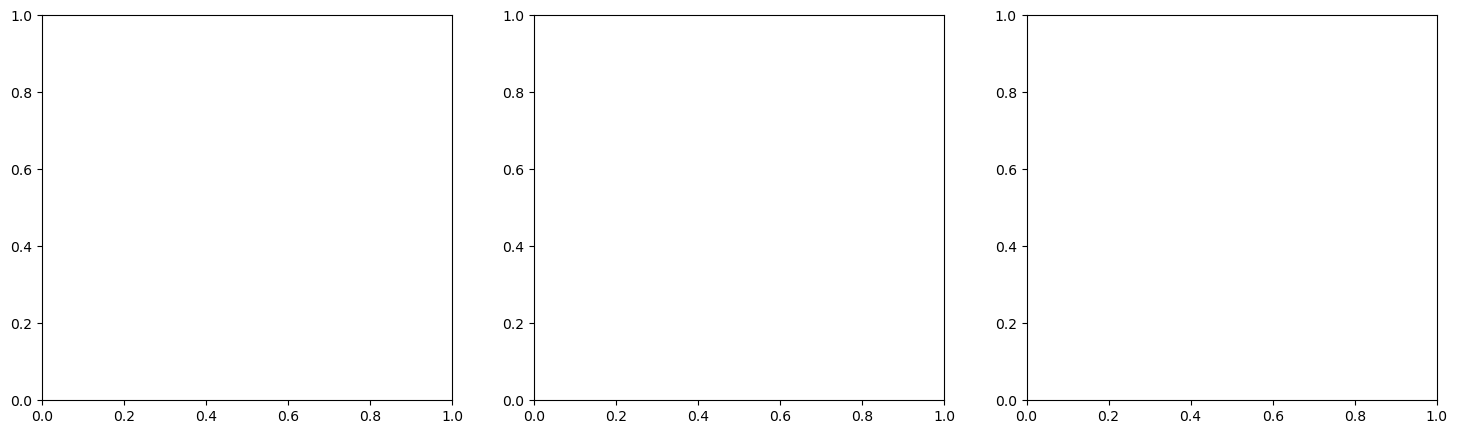

In [7]:
# Model evaluation

model_names = ["xgboost", "mlp", "RandomForest"]
class_labels = ["early", "middle", "late"]
splits = range(7)
all_results = []

for split_number in splits:
    print(f"=== Split {split_number} ===")
    fig, axes = plt.subplots(1, len(model_names), figsize=(6 * len(model_names), 5))
    metrics_list = []

    for i, name in enumerate(model_names):
        model_dir = f"../data/{name}"
        model_file = f"model_split_{split_number}"
        data_file = f"split_{split_number}_data.pkl"
        model_path = os.path.join(model_dir, model_file)
        data_path = os.path.join(model_dir, data_file)

        try:
            # Load test data and label encoder
            with open(data_path, "rb") as f:
                _, _, X_test, y_test, le, feature_cols = pickle.load(f)

            # === Handle PyTorch MLP ===
            if name == "mlp":
                model = MLP(input_dim=X_test.shape[1], num_classes=len(le.classes_)).to(DEVICE)
                model.load_state_dict(torch.load(model_path + ".pt", map_location=DEVICE))
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
                    y_pred = model(X_tensor).argmax(dim=1).cpu().numpy()
            else:
                # === Handle sklearn-based models ===
                model = joblib.load(model_path + ".joblib")
                y_pred = model.predict(X_test)

            # === Plot confusion matrix ===
            ConfusionMatrixDisplay.from_predictions(
                y_test,
                y_pred,
                display_labels=class_labels,
                normalize="true",
                ax=axes[i],
                vmin=0, vmax=1
            )
            axes[i].set_title(f"{name} (normalized)")
            

            # === Compute metrics ===
            metrics = {
                "Split": split_number,
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "F1": f1_score(y_test, y_pred, average="weighted", zero_division=0),
            }

            # Prevent duplicates
            if not any(r["Split"] == metrics["Split"] and r["Model"] == metrics["Model"] for r in all_results):
                metrics_list.append(metrics)

        except FileNotFoundError:
            print(f"Model or data missing for {name} (Split {split_number})")
            axes[i].set_visible(False)
            continue

    plt.suptitle(f"Normalized Confusion Matrices for Split {split_number}")
    plt.tight_layout()
    plt.show()

    if metrics_list:
        df_metrics = pd.DataFrame(metrics_list)
        display(df_metrics)
        all_results.extend(metrics_list)
    else:
        print("No models evaluated for this split.")

# === Show final results across all splits ===
df_all = pd.DataFrame(all_results)

# Display one summary table per model
for model in df_all["Model"].unique():
    print(f"\nSummary for {model.upper()}")
    df_model = df_all[df_all["Model"] == model].reset_index(drop=True)
    display(df_model)


## Further evalutation metrics

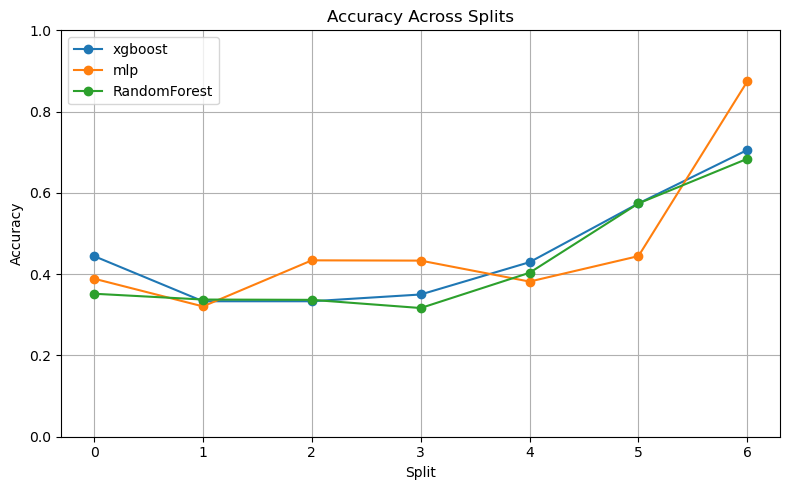

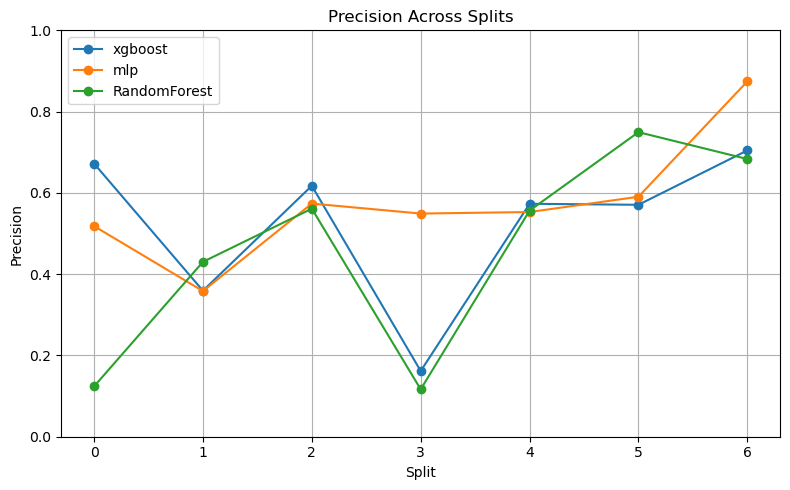

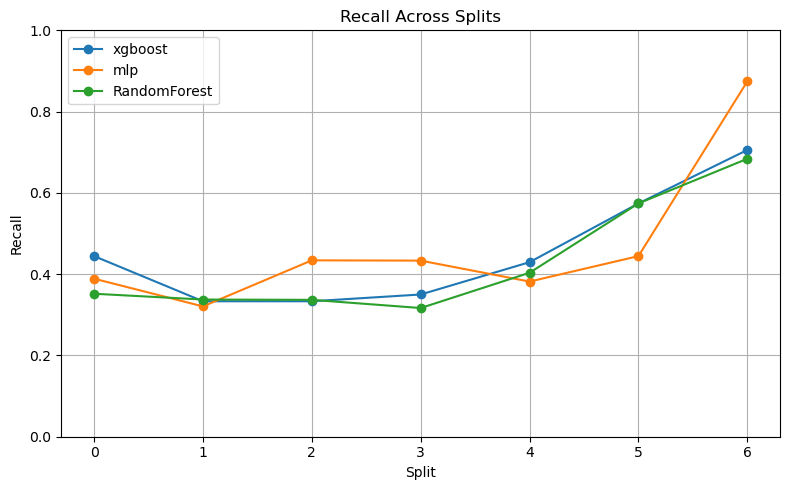

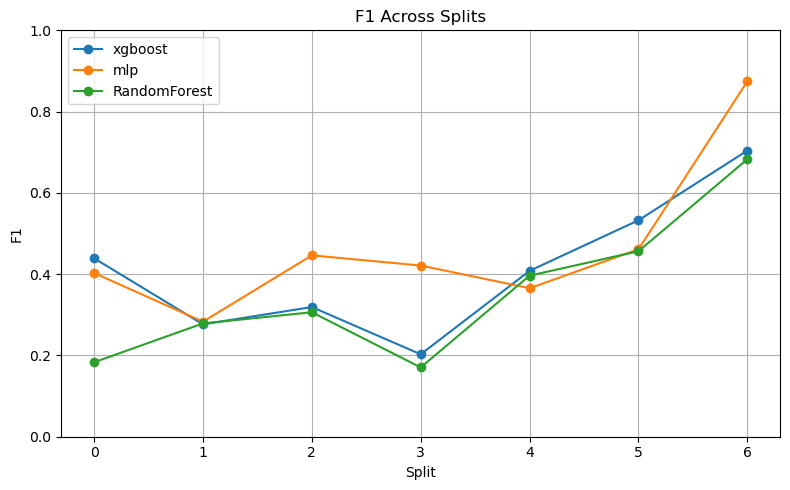

In [5]:
# Split Performance visualized

metrics = ["Accuracy", "Precision", "Recall", "F1"]

# Define color palette
color_palette = {
    "xgboost": "#1f77b4",
    "mlp": "#ff7f0e",
    "RandomForest": "#2ca02c"
}


for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model in df_all["Model"].unique():
        subset = df_all[df_all["Model"] == model]
        plt.plot(subset["Split"], subset[metric], label=model, marker='o')
    plt.title(f"{metric} Across Splits")
    plt.xlabel("Split")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

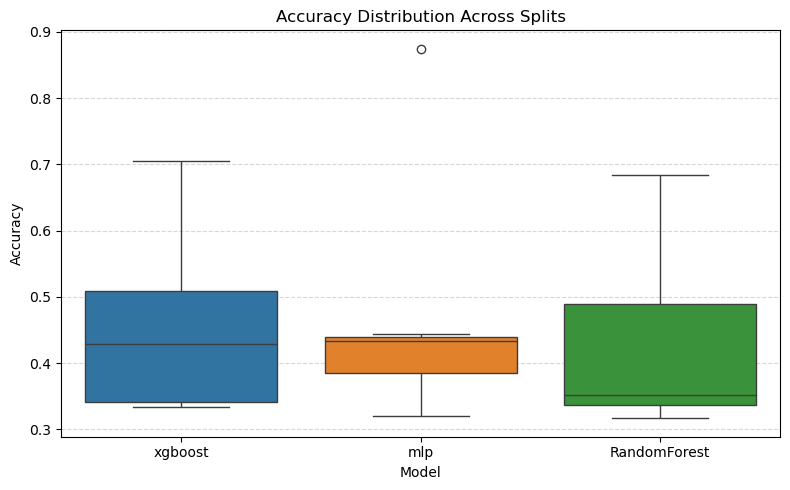

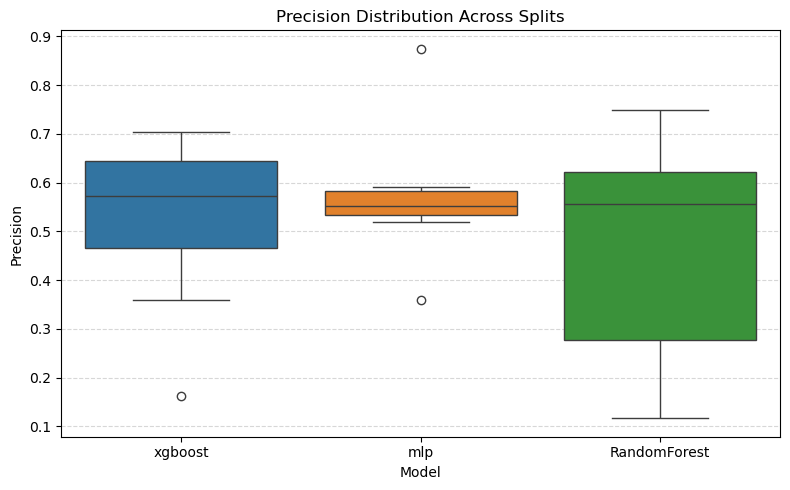

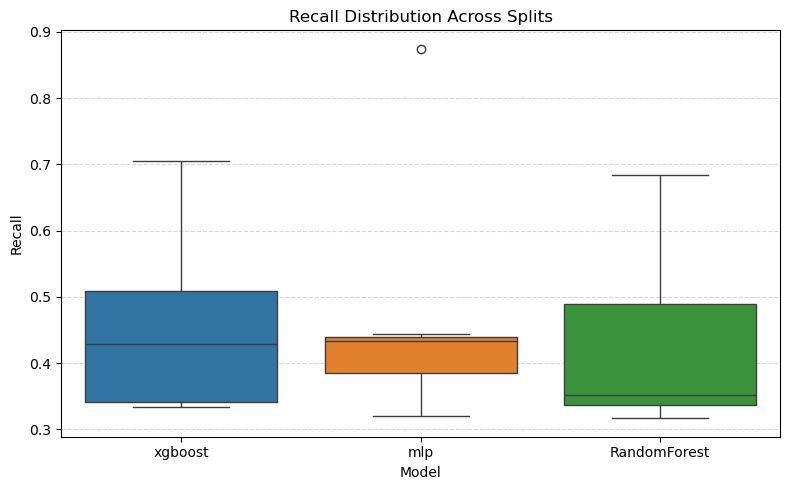

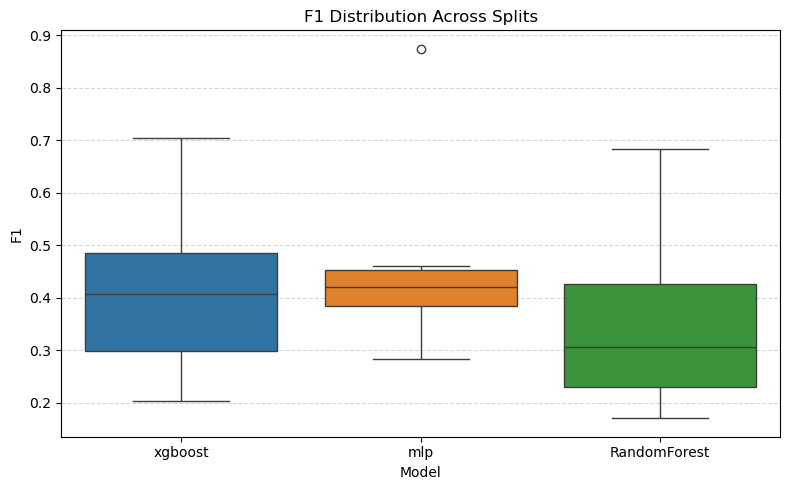

In [6]:
# Bar plot

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        x="Model",
        y=metric,
        hue="Model",         
        data=df_all,
        palette=color_palette,
        legend=False              
    )
    plt.title(f"{metric} Distribution Across Splits")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

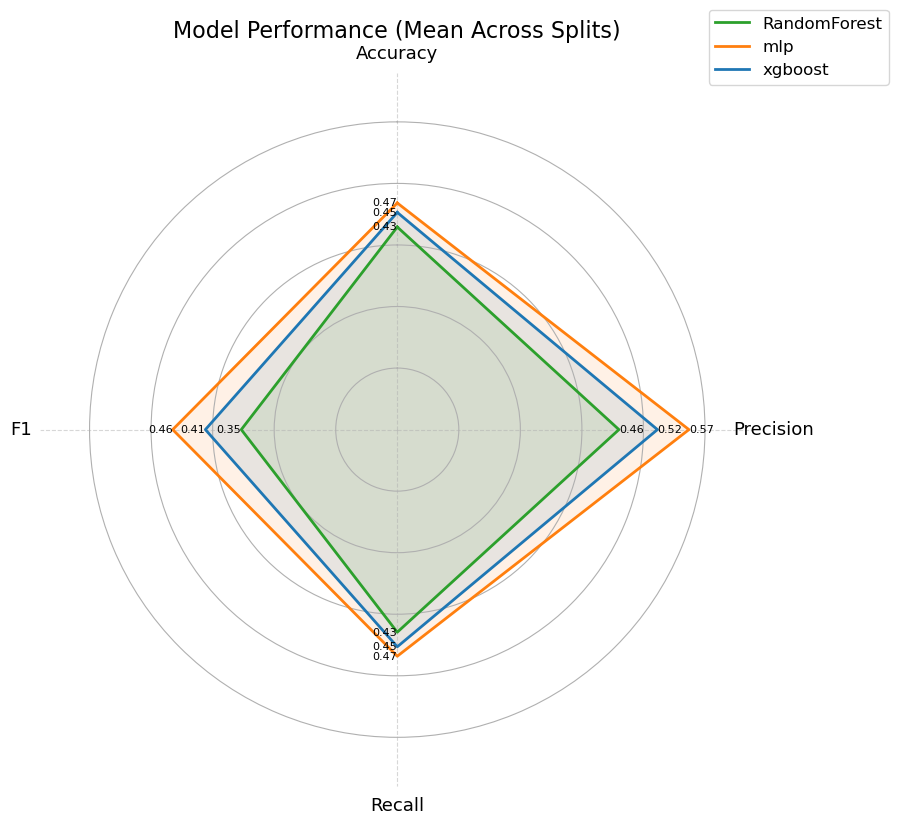

In [ ]:
# Spider plot

# Metrics and means
metrics = ["Accuracy", "Precision", "Recall", "F1"]
metrics_mean = df_all.groupby("Model")[metrics].mean().reset_index()

# Radar setup
labels = metrics
num_metrics = len(labels)
angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

# Plot each model
for _, row in metrics_mean.iterrows():
    model = row["Model"]
    values = row[metrics].tolist() + [row[metrics].tolist()[0]]
    color = color_palette[model]

    ax.plot(angles, values, label=model, linewidth=2, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

    # Annotate with slight angle-based offset
    for i in range(num_metrics):
        angle_rad = angles[i]
        value = values[i]
        ha = 'left' if 0 < angle_rad < np.pi else 'right'
        ax.text(
            angle_rad,
            value,
            f"{value:.2f}",
            color="black",
            fontsize=8,
            ha=ha,
            va='center'
        )

# Aesthetics
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=13)

# Clean background
ax.yaxis.grid(True)
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_ylim(0.1, 0.68)

# Title and legend
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=12)
plt.title("Model Performance (Mean Across Splits)", fontsize=16, pad=25)

plt.tight_layout()
plt.show()